In [1]:
import nltk
import pandas as pd
import json
import gc
import re
from nltk.util import ngrams
from nltk.stem.wordnet import WordNetLemmatizer
from datetime import datetime, timedelta
from nltk.corpus import stopwords

In [2]:
with open("D://Project2017/Product review/pd_reviews.json",encoding='utf8') as json_file:
    jsonVariable = json.load(json_file)

    
review_raw = pd.DataFrame(jsonVariable)
review = review_raw[['variation_asin','country','content','review_id','rating','review_date']]
review = review.rename(columns = {'variation_asin':'asin'})
review['review_date'] = review['review_date'].apply(pd.Series)
review['review_date'] = pd.to_datetime(review['review_date'])

print('All review :', review.shape[0])


All review : 86744


In [3]:
###  B012UNOCJY  >>>> SW2700PT,  country  ='com'
###  B012AQIOL8  >>>  UP2716

all_text = review[(review['asin'] == 'B012UNOCJY') & (review['country'] == 'com')]
star_mapping_tb = all_text[['review_id','rating']]
all_text = all_text[['asin','review_id','content','rating','review_date']]

print('Total length = ', all_text.shape[0])
all_text.tail(10)


review_pos = all_text[all_text['rating']>3]
review_neg = all_text[all_text['rating']<=3]


print('Positive length = ', review_pos.shape[0])
print('Negative length = ', review_neg.shape[0])



Total length =  88
Positive length =  72
Negative length =  16


In [4]:
remove_list = ['monitor','benq']

                                
def reg_exp(s_input):

    s_input = re.sub('\.\-',',',s_input)
    s_input = re.sub(r'(<br/>)=+(<br/>)','. ',s_input)
    s_input = re.sub(r'<br/><br/>','. ',s_input)
    s_input = re.sub(r'<br/>','. ',s_input)
    s_input = re.sub('\.{2,3}','. ',s_input)
    s_input = re.sub(r':',': ',s_input)
    s_input = re.sub(r'\"','',s_input)
    s_input = re.sub(r'(“|”)','',s_input)
    s_input = re.sub(r'\’','\'',s_input)
    
    #s_input = re.sub("(?<=[A-Za-z])[\.](?=[A-Za-z])", ". ", s_input)
    s_input = re.sub('\.\s+','. ',s_input)
    return s_input





def common_word_graph(df_wordset,remove_list,n):
    all_words = []

    for l in df_wordset:
        all_words = all_words+list(l)

    
    all_words = [word for word in all_words if word not in remove_list]
    freqwords = nltk.FreqDist(all_words)

    freqwords.plot(n,cumulative=False)

    
def common_word(df_wordset,remove_list):
    all_words = []
  
    for l in df_wordset:
        all_words = all_words+list(l)


    all_words = [word for word in all_words if word not in remove_list]
    freqwords = nltk.FreqDist(all_words)
    
    return freqwords.most_common()    
    
    
def extract_unigram_noun(text):
    stops = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    unigram_list = []
    unigrams_tag = nltk.pos_tag(nltk.word_tokenize(text.lower()))
    for u in unigrams_tag:
        if(u[1][0] == 'N'):
            unigram_list.append(u[0])
    
    unigrams = [lemmatizer.lemmatize(u) for u in unigram_list  if (u not in stops and u.isalnum())]
    
    return set(unigrams)
    



def extract_bigram(text):
    
    tokenized_words = nltk.word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    
    #lemma_words = [lemmatizer.lemmatize(u) for u in tokenized_words]
    
    # Filter out words that have punctuation and make everything lower-case
    stops = set(stopwords.words('english'))
    
    
    bigrams = [b for b in nltk.bigrams(tokenized_words) if (b[0] not in stops and b[1] not in stops) 
               and (b[0].isalnum() and b[1].isalnum()) and (b[0] not in remove_list and b[1] not in remove_list)
               and (not b[0].isdigit() and not b[1].isdigit())]
    
    
    
    bigram_lemma_list = []
    for i in bigrams:

        b1 = lemmatizer.lemmatize(i[0])
        b2 = lemmatizer.lemmatize(i[1])
        bigram_tuple = (b1,b2)
        bigram_lemma_list.append(bigram_tuple)
    
    bigram_list = []
    for i in bigram_lemma_list:

        bigram_string = ' '.join(i)
        bigram_list.append(bigram_string)
        
        
 



    

        
    
    return set(bigram_list)
   


In [5]:
review_pos['content'] = review_pos['content'].apply(reg_exp)
unigram_pos = review_pos['content'].apply(extract_unigram_noun)

review_neg['content'] = review_neg['content'].apply(reg_exp)
unigram_neg = review_neg['content'].apply(extract_unigram_noun)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


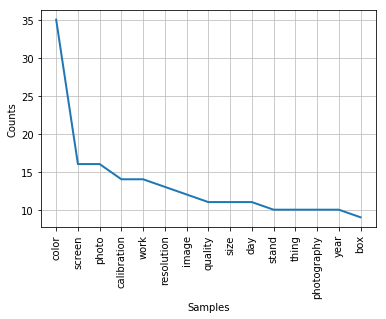

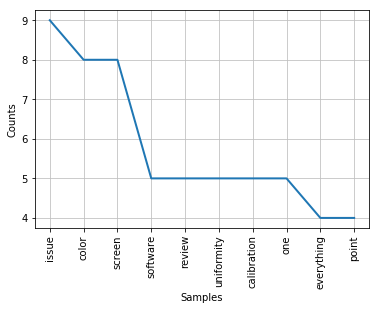

72988    {software, review, option, benq, everything, r...
72989            {support, picture, jumping, one, monitor}
73013    {monitor, benq, thats, rendition, light, repla...
73034    {card, online, review, gamut, cd, side, year, ...
73035    {inconsistency, photographer, side, difference...
73039    {software, review, time, unit, product, leblan...
73043    {model, hoping, review, side, result, guy, loo...
73045    {nec, year, bit, left, issue, panel, rating, r...
73052    {calibration, half, benq, center, c, cast, mon...
73058                                {build, quality, job}
73060    {dell, calibration, software, adobe, rgb, thou...
73062    {range, software, gamut, error, fact, limit, b...
73063    {try, professionalism, software, defect, spyde...
73068    {leak, anything, time, vignetting, truly, phot...
73069    {matter, time, back, order, good, benq, conver...
73075    {try, carpet, review, defect, stand, side, chu...
Name: content, dtype: object

In [6]:
common_word_graph(unigram_pos,remove_list,15)
unigram_pos

common_word_graph(unigram_neg,remove_list,10)
unigram_neg

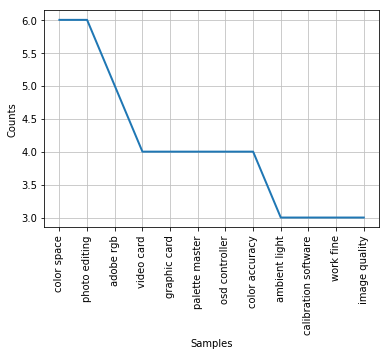

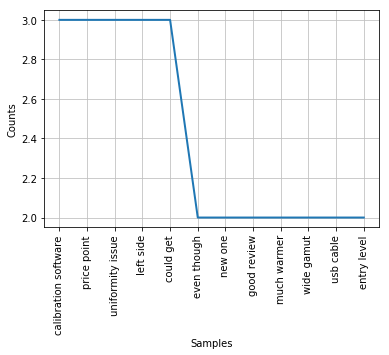

In [7]:
bigram_pos = review_pos['content'].apply(extract_bigram)
#bigram_pos  =bigram_pos.apply(word_Lemmatizer)
common_word_graph(bigram_pos,remove_list,12)

bigram_neg = review_neg['content'].apply(extract_bigram)
#bigram_pos  =bigram_pos.apply(word_Lemmatizer)
common_word_graph(bigram_neg,remove_list,12)